In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
train_file = "./train.csv"
test_file = "./test.csv"

In [3]:
dfTrain = pd.read_csv(train_file)
dfTest = pd.read_csv(test_file)
df = pd.concat([dfTrain,dfTest], sort=False)

In [4]:
num_cols = [
    "ps_reg_01", "ps_reg_02", "ps_reg_03",
    "ps_car_12", "ps_car_13", "ps_car_14", "ps_car_15"
]

ignore_cols = [
    "id", "target",
    "ps_calc_01", "ps_calc_02", "ps_calc_03", "ps_calc_04",
    "ps_calc_05", "ps_calc_06", "ps_calc_07", "ps_calc_08",
    "ps_calc_09", "ps_calc_10", "ps_calc_11", "ps_calc_12",
    "ps_calc_13", "ps_calc_14",
    "ps_calc_15_bin", "ps_calc_16_bin", "ps_calc_17_bin",
    "ps_calc_18_bin", "ps_calc_19_bin", "ps_calc_20_bin"
]

In [5]:
feature_dict = {}
total_feature = 0
for col in df.columns:
    if col in ignore_cols:
        continue
    elif col in num_cols:
        feature_dict[col] = total_feature
        total_feature += 1
    else:
        unique_val = df[col].unique()
        feature_dict[col] = dict(zip(unique_val,range(total_feature,len(unique_val) + total_feature)))
        total_feature += len(unique_val)

In [6]:
train_y = dfTrain[['target']].values.tolist()

In [7]:
dfTrain.drop(['target','id'],axis=1,inplace=True)
train_feature_index = dfTrain.copy()
train_feature_value = dfTrain.copy()

for col in train_feature_index.columns:
    if col in ignore_cols:
        train_feature_index.drop(col,axis=1,inplace=True)
        train_feature_value.drop(col,axis=1,inplace=True)
        continue
    elif col in num_cols:
        train_feature_index[col] = feature_dict[col]
    else:
        train_feature_index[col] = train_feature_index[col].map(feature_dict[col])
        train_feature_value[col] = 1

In [8]:
total_feature

257

In [9]:
train_feature_index

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15
0,0,8,13,25,28,36,38,40,42,44,...,130,133,135,141,144,248,253,254,255,256
1,1,9,14,26,28,36,39,41,42,44,...,130,134,136,141,145,249,253,254,255,256
2,2,10,15,25,28,36,39,41,42,44,...,130,134,136,141,146,250,253,254,255,256
3,3,9,16,26,28,37,39,40,42,44,...,130,134,137,141,147,250,253,254,255,256
4,3,8,17,25,28,37,39,40,42,44,...,130,134,136,141,148,249,253,254,255,256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595207,5,9,24,26,28,36,39,40,43,44,...,130,134,135,141,180,249,253,254,255,256
595208,2,9,19,26,28,36,39,40,43,44,...,132,133,136,141,228,248,253,254,255,256
595209,1,9,24,26,28,37,39,40,42,44,...,130,134,136,141,180,249,253,254,255,256
595210,2,8,19,25,28,36,39,41,42,44,...,130,134,136,141,154,249,253,254,255,256


In [10]:
len(train_feature_index.columns)

37

In [11]:
dfm_params = {
    "use_fm":True,
    "use_deep":True,
    "embedding_size":8,
    "dropout_fm":[1.0,1.0],
    "deep_layers":[32,32],
    "dropout_deep":[0.5,0.5,0.5],
    "deep_layer_activation":tf.nn.relu,
    "epoch":30,
    "batch_size":1024,
    "learning_rate":0.001,
    "optimizer":"adam",
    "batch_norm":1,
    "batch_norm_decay":0.995,
    "l2_reg":0.01,
    "verbose":True,
    "eval_metric":'gini_norm',
    "random_seed":3
}

In [12]:
dfm_params['feature_size'] = total_feature
dfm_params['field_size'] = len(train_feature_index.columns)

In [13]:
weights = dict()
weights['feature_embeddings'] = tf.Variable(tf.random.normal(shape=[dfm_params['feature_size'], dfm_params['embedding_size']], mean=0.0, stddev=0.01))
weights['feature_bias'] = tf.Variable(tf.random.normal(shape=[dfm_params['feature_size'], 1], mean=0.0, stddev=0.01))

#### load data

In [14]:
demo_index = tf.constant(train_feature_index[:3].values)
demo_val = tf.constant(train_feature_value[:3].values, dtype=tf.float32)

In [15]:
reshaped_demo_val = tf.reshape(demo_val, shape=[-1,dfm_params['field_size'],1])
reshaped_demo_val.shape

TensorShape([3, 37, 1])

#### fm

In [16]:
first_order = tf.nn.embedding_lookup(weights['feature_bias'],demo_index)
first_order.shape

TensorShape([3, 37, 1])

In [17]:
fm_first_order = tf.reduce_sum(tf.multiply(first_order,reshaped_demo_val),2)
fm_first_order.shape

TensorShape([3, 37])

In [18]:
embeddings = tf.nn.embedding_lookup(weights['feature_embeddings'],demo_index)
embeddings.shape

TensorShape([3, 37, 8])

In [19]:
second_inner = tf.multiply(embeddings,reshaped_demo_val)

In [20]:
summed_features_emb = tf.reduce_sum(second_inner,1)
summed_features_emb_square = tf.square(summed_features_emb)
summed_features_emb_square.shape

TensorShape([3, 8])

In [21]:
squared_features_emb = tf.square(second_inner)
squared_sum_features_emb = tf.reduce_sum(squared_features_emb,1)
squared_sum_features_emb.shape

TensorShape([3, 8])

In [22]:
fm_second_order = 0.5 * tf.subtract(summed_features_emb_square,squared_sum_features_emb)
fm_second_order.shape

TensorShape([3, 8])

#### dnn

In [23]:
nn_weight = dict()
nn_bias = dict()
initializer = tf.keras.initializers.GlorotNormal()
y_deep = tf.reshape(embeddings,shape=[-1,dfm_params['field_size'] * dfm_params['embedding_size']])
for layer in range(0, len(dfm_params['deep_layers'])):
    if layer==0:
        input_size = dfm_params['field_size'] * dfm_params['embedding_size']
        nn_weight[layer] = tf.Variable(initializer([input_size, dfm_params['deep_layers'][0]]))
    else:
        nn_weight[layer] = tf.Variable(initializer([dfm_params['deep_layers'][layer-1], dfm_params['deep_layers'][layer]]))

    nn_bias[layer] = tf.Variable(initializer([1, dfm_params['deep_layers'][layer]]))
    y_deep = tf.add(tf.matmul(y_deep,nn_weight[layer]), nn_bias[layer])
    y_deep = tf.nn.relu(y_deep)

In [24]:
y_deep.shape

TensorShape([3, 32])

In [25]:
concat = tf.concat([fm_first_order,fm_second_order,y_deep],axis=1)                        

In [26]:
concat.shape

TensorShape([3, 77])

In [27]:
concat_weight=dict()
concat_weight['projection']=tf.Variable(initializer([concat.shape[1], 1]))
concat_weight['bias']=tf.Variable(0.01)

In [28]:
out = tf.nn.sigmoid(tf.add(tf.matmul(concat,concat_weight['projection']),concat_weight['bias']))

In [29]:
out

<tf.Tensor: id=131, shape=(3, 1), dtype=float32, numpy=
array([[0.5394925 ],
       [0.54190785],
       [0.5383072 ]], dtype=float32)>

#### train 

In [30]:
class DeepFM(tf.keras.Model):
    def __init__(self, cfg):
        super(DeepFM, self).__init__()
        self.feature_size = cfg['feature_size']
        self.field_size = cfg['field_size']
        self.embed_size = cfg['embed_size']
        self.deep_nn = cfg['deep_nn']
        
        self.dropout_fm = cfg['dropout_fm']
        self.dropout_deep = cfg['dropout_deep']
        
        # fm        
        self.feature_weight = tf.keras.layers.Embedding(cfg['feature_size'], 1)
        self.feature_embed = tf.keras.layers.Embedding(cfg['feature_size'], cfg['embed_size'])

        # dnn
        for layer in range(len(cfg['deep_nn'])):
            setattr(self, 'dense_' + str(layer), tf.keras.layers.Dense(self.deep_nn[layer]))
            setattr(self, 'batchNorm_' + str(layer), tf.keras.layers.BatchNormalization())
            setattr(self, 'activation_' + str(layer), tf.keras.layers.Activation('relu'))
            setattr(self, 'dropout_' + str(layer), tf.keras.layers.Dropout(self.dropout_deep))
            
        self.fc = tf.keras.layers.Dense(1, activation='sigmoid', use_bias=True)

    def call(self, feature_idx, feature_val, training=None):
        reshaped_feature_val = tf.reshape(feature_val, shape=[-1,self.field_size,1])
        # linear        
        weights = self.feature_weight(feature_idx)
        linear = tf.reduce_sum(tf.multiply(weights,reshaped_feature_val),2)
        
        # fm  
        embeddings = self.feature_embed(feature_idx)
        second_inner = tf.multiply(embeddings,reshaped_feature_val)
        
        summed_features_emb = tf.reduce_sum(second_inner,1)
        summed_features_emb_square = tf.square(summed_features_emb)
        
        squared_features_emb = tf.square(second_inner)
        squared_sum_features_emb = tf.reduce_sum(squared_features_emb,1)
        
        fm = 0.5 * tf.subtract(summed_features_emb_square,squared_sum_features_emb)
        
        # dnn
        y_deep = tf.reshape(embeddings,shape=[-1,self.field_size * self.embed_size])
        for layer in range(0, len(self.deep_nn)):
            y_deep = getattr(self, 'dense_' + str(layer))(y_deep)
            y_deep = getattr(self, 'batchNorm_' + str(layer))(y_deep)
            y_deep = getattr(self, 'activation_' + str(layer))(y_deep)
            y_deep = getattr(self, 'dropout_' + str(layer))(y_deep)
            
        # concat
        concat = tf.concat([linear, fm, y_deep], axis=1)                                
        out = self.fc(concat)
        return out

In [40]:
def train_step(x_idx, x_val, y):
    model = DeepFM(cfg)
    with tf.GradientTape() as tape:
        y_ = model(x_idx, x_val)
        # tf.print('pred:', y_)
        bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        loss = bce(y_true=y, y_pred=y_)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    # print("train loss: ", loss)
    return loss

In [53]:
demo_index = tf.constant(train_feature_index.values)
demo_val = tf.constant(train_feature_value.values, dtype=tf.float32)
demo_label = train_y

In [42]:
cfg = {
    "feature_size": total_feature,
    "field_size": len(train_feature_index.columns),
    "embed_size":8,
    "deep_nn":[32,32],
    "dropout_fm": 0,
    "dropout_deep": 0.2,
    "epoch":100
}

In [34]:
# train_step(demo_index, demo_val, demo_label)

In [58]:
epoch_list = []
loss_trend = []

In [59]:
def train(demo_index, demo_val, demo_label, epoch):
    for i in range(int(epoch)):
        loss = train_step(demo_index, demo_val, demo_label)
        epoch_list.append(i)
        loss_trend.append(loss)
#        print('epoch: '+str(i), end='\t')
#        print("loss: ", loss.numpy())
        

In [60]:
train(demo_index, demo_val, demo_label, cfg['epoch'])

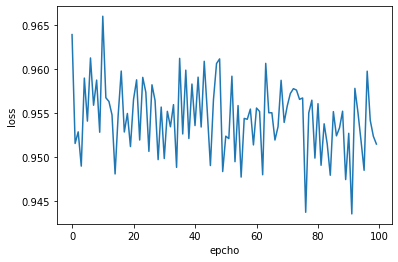

In [61]:
from matplotlib import pyplot as plt

plt.xlabel('epcho')
plt.ylabel('loss')
plt.plot(epoch_list, loss_trend)
plt.show()

In [67]:
dataset = tf.data.Dataset.from_tensor_slices((train_feature_index.values, 
                                              train_feature_value.values,
                                              pd.DataFrame(train_y).values))
for idx, val, label in dataset.take(5):
    print('idx: {}, val: {}, label: {}'.format(idx, val, label))

idx: [  0   8  13  25  28  36  38  40  42  44  46  48  50  52  57  71  73  75
  77  78  79  80  93  96  99 109 112 130 133 135 141 144 248 253 254 255
 256], val: [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.7        0.2        0.71807033 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.4        0.88367892 0.37080992
 3.60555128], label: [0]
idx: [  1   9  14  26  28  36  39  41  42  44  46  48  50  52  58  71  74  76
  77  78  79  81  93  96  99 110 113 130 134 136 141 145 249 253 254 255
 256], val: [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.8        0.4        0.76607767 1.         1.         1.
 1.         1.         1.         1.         1.    